In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
from models import clean_raw_text_and_verify, find_uncoded_stuff_and_retun_words_as_array

Using TensorFlow backend.


In [3]:
raw_text = open('cien sonetos de amor.txt').readlines()

In [17]:
# Por linea (es decir, una linea es una componente de la lista)
raw_text_cleanned = clean_raw_text_and_verify(raw_text)

In [5]:
# Cada palabra es una componente de la lista
text_array_as_words = find_uncoded_stuff_and_retun_words_as_array(raw_text_cleanned)

In [22]:
from collections import Counter
vocab = list(Counter(text_array_as_words))
word_to_index = {word:i+1 for i, word in enumerate(vocab)}
index_to_word = {i+1:word for i, word in enumerate(vocab)}
coded_text = [word_to_index[word] for word in text_array_as_words]

In [23]:
coded_text[:20]

[1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 3, 10, 5, 11, 12, 13, 5, 14, 15, 16]

In [21]:
print(text_array_as_words[:20])

['start_soneto', 'matilde', 'char_comma', 'nombre', 'de', 'planta', 'o', 'piedra', 'o', 'vino', 'char_comma', 'char_new_line', 'de', 'lo', 'que', 'nace', 'de', 'la', 'tierra', 'y']


In [40]:
coded_versos = []
accum = []
sizes = []
for code in coded_text:
    if code not in [word_to_index['char_new_line'], word_to_index['start_soneto'], word_to_index['end_soneto']]:
        accum.append(code)
    else:
        # End_soneto
        if (len(accum)>0):
            coded_versos.append(accum)
            sizes.append(len(accum))
            accum = []

In [41]:
max(sizes)

17

In [42]:
np.save('word_to_index', word_to_index)
np.save('index_to_word', index_to_word)

In [43]:
def window_transform_codes_padding_mode(codes):
    len_out = len(codes)
    
    #output_start[-1] = text[:1]
    #output_start[len_out-1:len_out-2] = text[0:1]
    X = []
    y = []
    for i in range(len_out):
        #X.append()
        output_start = [0]*(len_out-1)
        output_start[len_out-i-1:len_out] = codes[0:i]
        X.append(output_start)
        y.append(codes[i])
    return X, y

In [44]:
from keras.utils import to_categorical
max_length = max(sizes)
X_train = np.array([]).reshape(-1, max_length)
y_train = []
for coded_verso in coded_versos:
    X_son_train, y_son_train = window_transform_codes_padding_mode(coded_verso)
    X_son_train = np.array(X_son_train)
    padding = np.zeros((X_son_train.shape[0], max_length - X_son_train.shape[1]))
    X_son_train = np.hstack([padding,X_son_train ])
    X_train = np.vstack([X_train, X_son_train]).astype(int)
    y_train = y_train + y_son_train
y_train = np.array(y_train)   
y_train = to_categorical(np.array(y_train)-1)

In [45]:
X_train.shape, y_train.shape

((12033, 17), (12033, 2563))

In [53]:
from models import get_model_4

In [105]:
from fnn_helper import PlotLosses
model4 = get_model_4(len(vocab), lstm_units=128, word_dim=64)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          164096    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_10 (Dense)             (None, 2563)              330627    
Total params: 593,539
Trainable params: 593,539
Non-trainable params: 0
_________________________________________________________________


In [106]:
from keras import optimizers

In [107]:
adam = optimizers.Adam(lr=0.001) #lr=0.001 default

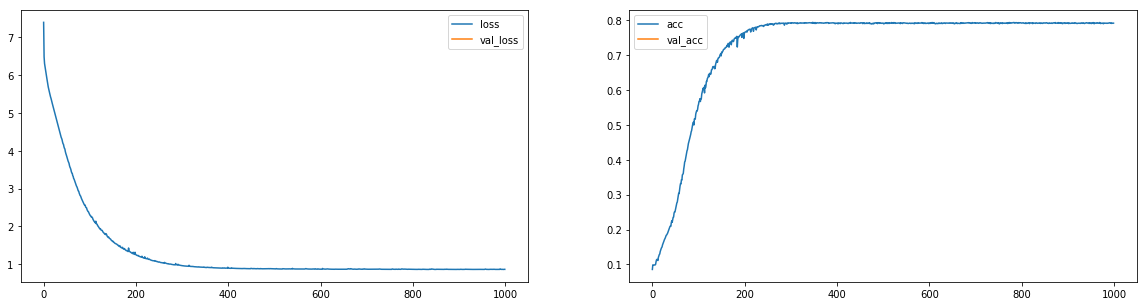

12033/12033 [==============================] - 12s 989us/step - loss: 0.8639 - acc: 0.7917


In [108]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None)
model4.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model4.fit(X_train, y_train, batch_size=256, epochs=1000, verbose = 1, callbacks=[plot_losses])

In [109]:
model4.save_weights('model4-emb-64-units-64-epochs-1000-versos.hdf5')
#model4.load_weights('model4-emb-16-units-64-epochs-800-rmsprop.hdf5')

In [110]:
model4.predict(X_train[0:1])

array([[  3.40174400e-09,   3.44090629e-03,   2.38804205e-04, ...,
          6.63723738e-04,   7.21210380e-09,   3.30545333e-08]], dtype=float32)

In [117]:
X_train[0:1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [113]:
from models import get_model_4_statefull, words_to_punctuation

In [115]:
model4s = get_model_4_statefull(len(vocab), lstm_units=128, word_dim=64)
model4s.load_weights('model4-emb-64-units-64-epochs-1000-versos.hdf5')

In [128]:
word_to_index['']=0

In [129]:
model4s.reset_states()
word = ''
#word='Pero'
probs = model4s.predict(np.array(word_to_index[word]).reshape(1,1))[0]
idxs = np.argsort(probs)[::-1][:20]

print(list(map(index_to_word.get,idxs+1)))
print((probs[idxs]*100).astype(int)/100)

['y', 'la', 'de', 'el', 'que', 'en', 'no', 'por', 'como', 'hasta', 'con', 'a', 'tu', 'char_exclamation_open', 'pero', 'yo', 'una', 'las', 'mi', 'te']
[ 0.12  0.03  0.03  0.03  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01]


In [132]:
model4s.reset_states()
#word_list = ['', 'recordarás']
#word_list = ['', 'matilde']
#word_list = ['', 'amor']
#word_list = ['', 'tienes']
#word_list = ['', 'el']
#word_list = ['', 'la']
word_list = ['', 'la']

codes_list = list(map(word_to_index.get, word_list))

for code in codes_list:
    probs = model4s.predict(np.array(code).reshape(-1,1))[0]
    idx = np.argmax(probs)
    pred_word = index_to_word[idx+1]

for word in word_list[1:]:
    print(word, end =' ')
for i in range(200):
    word = pred_word
    if word=='end_soneto':
        break
    probs = model4s.predict(np.array(word_to_index[word]).reshape(1,1))[0]
    idx = np.argmax(probs)
    print(words_to_punctuation(word), end=' ')
    pred_word = index_to_word[idx+1]

la noche, el mundo, el viento devanan su destino, la vaga red del día. char_close_parent, la vaga red del día. char_close_parent, la vaga red del día. char_close_parent. tus penas, tus pueblos diminutos, resurrectos, sellamos el silencio, compañera. la vaga red del día. arena, tus,, te alma. arena. te alma,, la morada: mi recibe, tus manos,, de mis sentidos,. de mis sentidos., de nenúfar, de las desgarraduras, tres tijeras. de mis sentidos., de nenúfar, de las desgarraduras, tres tijeras. tres tijeras. tres tijeras. tres tijeras. tres tijeras. tres tijeras. tres tijeras. tres tijeras. tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres tijeras, tres 

In [166]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
word_dim = 16
model_4_emb = Sequential()
model_4_emb.add(Embedding(len(vocab)+1, word_dim, mask_zero = True, name='Embedding'))
model_4_emb.get_layer('Embedding').set_weights(model4.get_layer('embedding_6').get_weights())

In [222]:
all_unique_words_coded = np.linspace(1, len(vocab), len(vocab)).astype(int)
embedded_words = model_4_emb.predict(all_unique_words_coded).reshape(len(all_unique_words_coded), word_dim)

In [260]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(embedded_words)
distances, indices = nbrs.kneighbors(embedded_words)

In [276]:
word = 'el'
#word = 'las'
word_idx = word_to_index[word]
print(word)
print(list(map(index_to_word.get,1+indices[word_idx-1,1:])))
print(distances[word_idx-1,1:])

el
['su', 'al', 'cuenta', 'del', 'áridas', 'agregaron', 'reinó', 'lejana', 'solo']
[ 0.11978358  0.13284248  0.1493125   0.205257    0.22169918  0.23117959
  0.23147947  0.23547566  0.23978144]


In [160]:
top_100_common_words = []
top_100_common_codes = []
for word in dict(Counter(text_array_as_words).most_common(200)).keys():
    if (word not in ['char_question_open', 'char_question_close', 'char_new_line', 'char_comma', 'char_dot', 'start_soneto', 'end_soneto', 'char_dos_puntos', 'char_exclamation_open', 'char_exclamation_close']):
        top_100_common_words.append(word)
        top_100_common_codes.append(word_to_index[word])

In [ ]:
embedded_words = model_4_emb.predict(all_unique_words_coded).reshape(len(all_unique_words_coded), word_dim)

In [169]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedded_words)
X_embedded.shape

(190, 2)

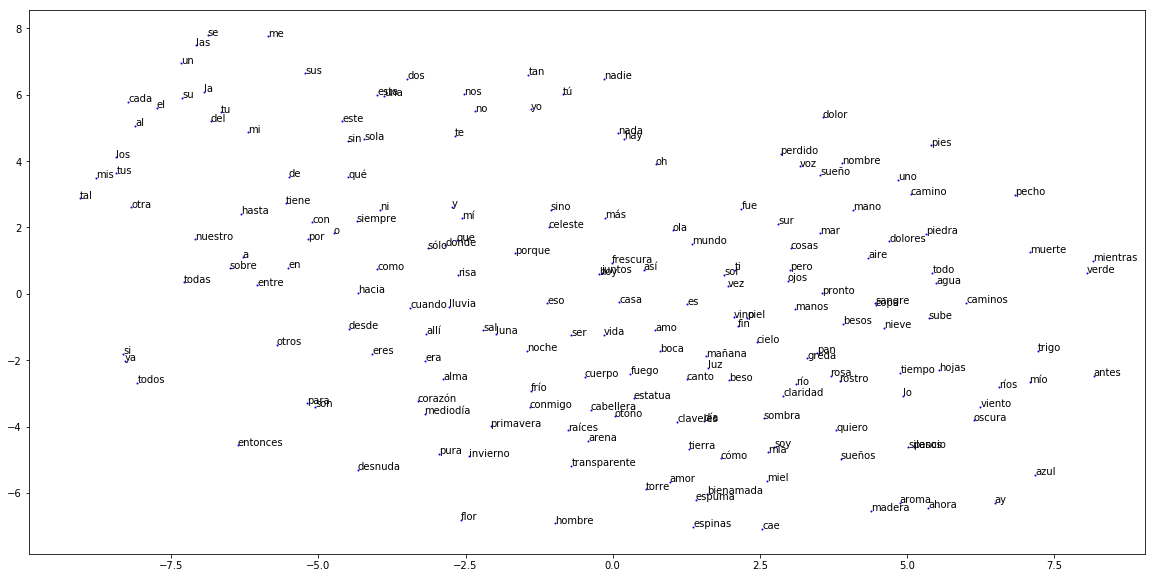

In [170]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
for i, point in enumerate(X_embedded):
    plt.scatter(point[0], point[1], c='b', s=1)
    plt.text(point[0], point[1], str(top_100_common_words[i]))
plt.show()